In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(1697, 35)
(1697, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL/RR are swinging
idxs = np.where(X_motion[:, -2] == 1)[0]
X_motion_RR_swinging = X_motion[idxs]
Y_motion_RR_swinging = Y_motion[idxs]

## Predict RR foot -> x

In [8]:
X_motion_RR_swinging[0, :]

array([ 1.00000000e-01,  0.00000000e+00,  0.00000000e+00,  2.33885196e-01,
        1.22795058e-01, -3.56189429e-01,  2.65465053e-01, -1.27906489e-01,
       -3.38829276e-01, -2.53287380e-01,  1.35086166e-01, -3.40693485e-01,
       -2.83263581e-01, -1.30267708e-01, -3.55963468e-01,  3.16466436e+02,
        3.00874412e+01,  3.83206820e-01,  1.37700952e-03,  1.34801891e-03,
        1.30458770e-01,  9.91451863e-01,  4.30691366e-02,  2.55369556e-02,
        8.54699341e-03, -2.60550829e-03, -2.24758668e-02,  1.12350470e-02,
                   nan,             nan,  1.00000000e-01,  0.00000000e+00,
        0.00000000e+00,  1.00000000e+00,  0.00000000e+00])

In [9]:
Y_motion_RR_swinging[0, :]

array([ 0.05068422,  0.00809325,  0.04879678, -0.0021209 ])

### Linear Regression

In [10]:
# Input
X = np.hstack((X_motion_RR_swinging[:, :3], # Previous motion command
               X_motion_RR_swinging[:, -5:-2], # Current motion command
               X_motion_RR_swinging[:, 3:5], # FL (x,y) position
               X_motion_RR_swinging[:, 6:8], # FR (x,y) position
               X_motion_RR_swinging[:, 9:11], # RL (x,y) position
               X_motion_RR_swinging[:, 12:14])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RR_swinging[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_x = LinearRegression()

# Fit the model
model_rr_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9921992232778838
RMSE:  0.008216558308272464
The lowest error is:  0.0001442575965341364
The highest error is:  0.02913632548334827
The avg. error is:  0.006245067119768343


In [11]:
model_rr_relative_swinging_x.coef_

array([[-2.12722702e-02, -2.22044605e-16,  5.55111512e-17,
         3.07815893e-01,  1.11022302e-16, -3.05311332e-16,
        -7.84851657e-01, -4.60585789e-01, -3.94081915e-02,
        -6.49115861e-01,  8.24611757e-01,  4.68265821e-01,
        -2.69368127e-01,  6.63583128e-01]])

In [12]:
model_rr_relative_swinging_x.intercept_

array([0.34665231])

Text(0, 0.5, 'Predictions')

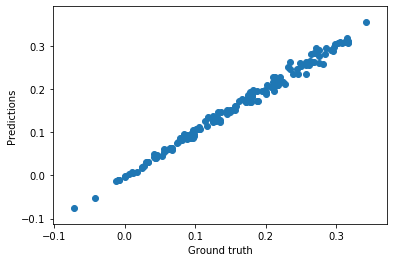

In [13]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [14]:
#%store model_rr_relative_swinging_x

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [16]:
# Save model
#joblib.dump(model_rr_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_x.sav")

### Predict RR foot -> y

In [17]:
# Input
X = np.hstack((X_motion_RR_swinging[:, :3], # Previous motion command
               X_motion_RR_swinging[:, -5:-2], # Current motion command
               X_motion_RR_swinging[:, 3:5], # FL (x,y) position
               X_motion_RR_swinging[:, 6:8], # FR (x,y) position
               X_motion_RR_swinging[:, 9:11], # RL (x,y) position
               X_motion_RR_swinging[:, 12:14])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RR_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_y = LinearRegression()

# Fit the model
model_rr_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.7026824656411625
RMSE:  0.006973177157710533
The lowest error is:  2.514937146122498e-05
The highest error is:  0.020529566204967847
The avg. error is:  0.005467471771502949


In [18]:
model_rr_relative_swinging_y.coef_

array([[ 2.94278278e-02,  1.28716482e-15,  5.96744876e-16,
        -4.54636556e-02,  1.15359111e-15, -1.24900090e-16,
         4.15687426e-01,  1.82894312e-01, -1.48269095e+00,
         2.84728612e-01,  1.35800803e+00,  8.38018878e-01,
        -3.72736013e-01, -1.61966451e+00]])

In [19]:
model_rr_relative_swinging_y.intercept_

array([0.22938063])

Text(0, 0.5, 'Predictions')

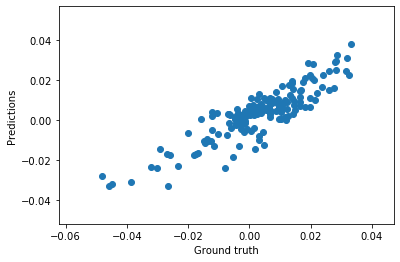

In [20]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [21]:
#for idx, prediction in enumerate(predictions):
#    print(f'Input: {X_test[idx]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')